In [1]:
#-- IMPORTING MODULES --
import numpy as np
import mpmath as mp

import math
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.optimize import fsolve
import scipy.misc
from scipy.misc import derivative
import scipy.interpolate
from scipy.interpolate import griddata
from scipy.integrate import quad, trapz, cumtrapz, romberg, fixed_quad, odeint, ode
from scipy import linalg
from numpy.linalg import inv
from scipy.special import gamma, hyp1f1
from scipy.interpolate import interp1d
import time
from astropy.table import Table, Column, MaskedColumn

#Atropy cosmology modules
import astropy.units as astrou
from astropy.cosmology import Planck18_arXiv_v2 as cosmo
from astropy.cosmology import z_at_value
from astropy.io import fits

# Import mycode
import sys
path = '/Users/feixu/OneDrive - The University of Chicago/Documents/Research'
sys.path.append(path+'/mycode/')
sys.path.append(path+'/lensingFei/')
import constantfei 
from detector_snr_fei import *
from optical_depthfei import *
from gw import *


#Plotting
from matplotlib.ticker import ScalarFormatter
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fontSz = 15
fontsz = 13
fontssz = 11

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

#Export results folder
import sys
dir_base=sys.path[0]
dir_out1=dir_base+"/plots_py_gw_lensing/"
dir_out2=dir_base+"/fits_py_gw_lensing/"

         	Approximation will be used...


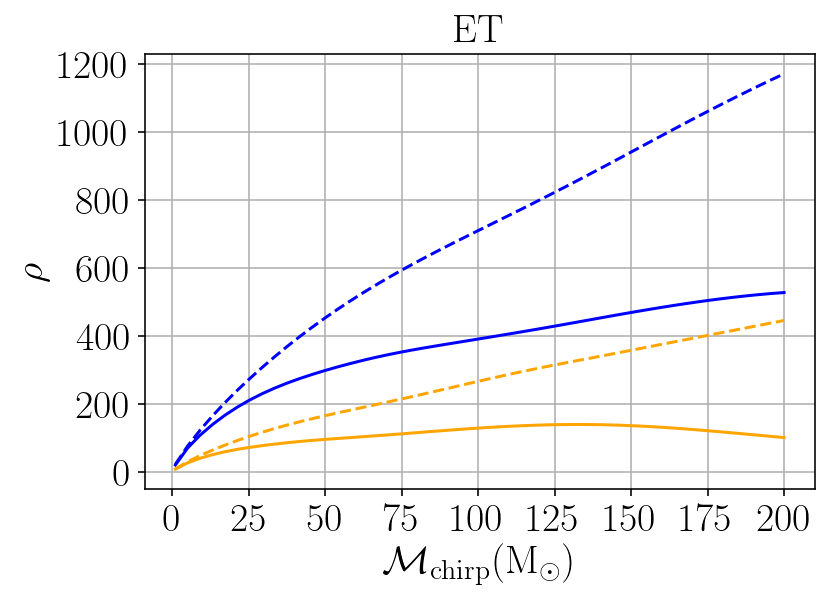

In [2]:
mchirpl = np.linspace(1, 200., num=50);
plt.plot(mchirpl, rho_opt_ET(0.5, mchirpl, 0.1), color='blue')
plt.plot(mchirpl, rho_opt_ET(0.5, mchirpl, 1), '--', color='blue')

plt.plot(mchirpl, rho_opt_ET(1.5, mchirpl, 0.1), color='orange')
plt.plot(mchirpl, rho_opt_ET(1.5, mchirpl, 1), '--', color='orange')

plt.xlabel(r'$\rm \mathcal{M}_{chirp} (M_\odot)$', fontsize=20)
plt.ylabel(r'$\rho$', fontsize=20)
plt.title(r'ET', fontsize=20)

plt.xticks(size=20)
plt.yticks(size=20)

plt.grid(True)

### This notebook calculates: $ p_\text{det}(\mathcal{M}, q, z) = p(\mathcal{M}, q)\cdot P(\rho_\text{thr}/ \rho_\text{opt}(\mathcal{M}, q, z))\$

#### Read $p(\mathcal{M}, q)$

In [3]:
#### Read in Mchirp, q distribution generated from ITM (See P(Mchirp, q) 2D interpolation.ipynb)
hdul = fits.open(dir_out2+'Pchirpq_2Dfei_referee.fits')
data1 = hdul[1].data
mchirp_2d = data1['mchirp_2d']
qratio_2d = data1['qratio_2d']
pdf_2d = data1['pdf_2d']

In [4]:
Pchirpq_2d = interpolate.interp2d(mchirp_2d, qratio_2d, pdf_2d, kind='linear', fill_value = 0., bounds_error = False)

In [5]:
mchirp_2d.shape

(49,)

In [6]:
Pchirpq_2d(np.min(mchirp_2d), np.min(qratio_2d)), Pchirpq_2d(np.min(mchirp_2d), np.max(qratio_2d))

(array([0.]), array([0.00160133]))

In [10]:
mchirpl = np.linspace(np.min(mchirp_2d), np.max(mchirp_2d), num=90); 
qratiol = np.linspace(np.min(qratio_2d), np.max(qratio_2d), num=80)
MCHIRPL = np.zeros((len(mchirpl), len(qratiol)))
QRATIOL = np.zeros((len(mchirpl), len(qratiol)))
TEMP = np.zeros((len(mchirpl), len(qratiol)))

for i in range(len(mchirpl)):
    for j in range(len(qratiol)):

        MCHIRPL[i, j] = mchirpl[i]
        QRATIOL[i, j] = qratiol[j]
        
        TEMP[i, j] = Pchirpq_2d(mchirpl[i], qratiol[j])
        

MCHIRPL = np.transpose(MCHIRPL)
QRATIOL = np.transpose(QRATIOL)
TEMP = np.transpose(TEMP)

In [11]:
zl_ET = np.linspace(1e-8, 50, num=25)
Pdet_ET_spl = []
fractz_ET = []
rhooptl_ET = []

for z0 in zl_ET:
    
    start = time.time()
    
    rhooptl_ET.append(rho_opt_ET(z0, MCHIRPL, QRATIOL))
    #print('***')
    fractl_ET = TEMP*P_detect(rhooptl_ET[-1])
    
    #print(fractl_ET.shape)
    
    fractz_ET.append(np.sum(np.sum((mchirpl[1]-mchirpl[0])*fractl_ET, axis=0)*(qratiol[1]-qratiol[0])))
    
    #Pdet_ET_spl.append(interpolate.interp2d(mchirpl, qratiol, fractl_ET, kind='linear', fill_value = 0.))
    #Pdet_ET = Pdet_ET_spl[-1]
    #f = lambda y, x: Pdet_ET(x, y)
    #fractz_ET.append(integrate.dblquad(f, 1., 50., lambda x: 0., lambda x: 1.)[0])
    print(fractz_ET[-1])
    end = time.time()
    #
    print(end-start)
    

0.9655650862595692
39.453474044799805
0.5982089416280155
82.34792423248291
0.35692187327174824
119.37031698226929
0.23800525512854256
136.16182494163513
0.1701604606006068
134.10868215560913
0.1278265364835715
150.2884590625763
0.09992399067051184
163.74133801460266
0.08092969327504965
166.60499596595764
0.06766877791266228
166.12359809875488
0.0580427963886779
172.46912217140198
0.05066587852075149
176.47660899162292
0.04457235601447207
212.78322196006775
0.03919493949319536
193.89704179763794
0.03418633670032261
181.1033148765564
0.02939898362669802
1097.815090894699
0.024798488824940484
184.46229100227356
0.02044979827105029
201.28662610054016
0.016510507996889523
191.16322994232178
0.013018288149520602
3149.5135600566864
0.00995495991573022
246.82953071594238
0.007358936329083252
203.1772141456604
0.005275973719332019
288.03016114234924
0.003710862921817666
250.19998407363892
0.0025966158283741
219.42252397537231
0.0018123241593710922
236.6351020336151


In [13]:
# Save p_det
fractz_ET = np.array(fractz_ET)
fractz_ET[np.isnan(fractz_ET)] = 0.

rhooptl_ET = np.array(rhooptl_ET)
t = Table([zl_ET, rhooptl_ET, fractz_ET], \
              names=['zl_ET', 'rhooptl_ET', 'fractz_ET'], masked=True)
t.write(dir_out2+'fractz_ET_snrcorrect2_referee.fits', format='fits', overwrite=True) 


In [52]:
fractz_ET = np.array([0.9655650862595692,\
41.775696992874146,\
0.8092307819763316,\
54.82324004173279,\
0.6054875510668837,\
80.10938477516174,\
0.4613149772510941,\
106.70151591300964,\
0.3635839182888341,\
110.46420192718506,\
0.2944693240473952,\
118.33249306678772,\
0.2434353504189131,\
134.1990830898285,\
0.2046472913813751,\
139.55186104774475,\
0.1745237464196412,\
135.96247482299805,\
0.1506268657781314,\
139.59113717079163,\
0.1313618140866901,\
135.98814487457275,\
0.1156663391227128,\
144.4988489151001,\
0.1027791764933732,\
145.7866449356079,\
0.0921168939747612,\
153.47370386123657,\
0.0832347910005008,\
164.5038800239563,\
0.0757999242951650,\
152.4258370399475,\
0.0695379934231832,\
170.0932011604309,\
0.0642079580485439,\
152.8520109653473,\
0.0596093901891566,\
153.51067280769348,\
0.0555958095049571,\
149.0030872821808,\
0.0520402164884072,\
152.49323272705078,\
0.0488255944999622,\
171.70664620399475,\
0.0458628201673288,\
155.64791297912598,\
0.0430929964547092,\
174.5626721382141,\
0.0404677644021978,\
167.61159873008728,\
0.0379426178272207,\
170.3506441116333,\
0.0354900865610258,\
174.6752679347992,\
0.0330949370909042,\
176.78652596473694,\
0.0307478825652102,\
254.4868791103363,\
0.0284444036265372,\
187.90000319480896,\
0.0261853433750009,\
436.4060859680176,\
0.0239769310756979,\
182.3269820213318,\
0.0218328190981330,\
176.7579050064087,\
0.0197748039819879,\
218.57936906814575,\
0.0178236977321585,\
182.48393297195435,\
0.0159856843171878,\
191.32089114189148,\
0.0142521417498039,\
192.77544713020325,\
0.0126197417067365,\
195.9190158843994,\
0.0110902840733857,\
192.1721088886261,\
0.0096677317501884,\
802.1317980289459,\
0.0083586441724592,\
213.11834383010864,\
0.0071692279523366,\
205.78869009017944,\
0.0061041582580797,\
216.08179116249084,\
0.0051655611868088,\
204.90698981285095,\
0.0043520054977996,\
214.07141017913818,\
0.0036572814744663,\
226.2441349029541,\
0.0030706080667543,\
281.4118902683258,\
0.0025777505207837,\
207.340026140213,\
0.0021632037467321,\
395.0689117908478,\
0.0018123241593710,\
218.35509705543518])
fractz_ET = fractz_ET[np.where(fractz_ET < 1.)]

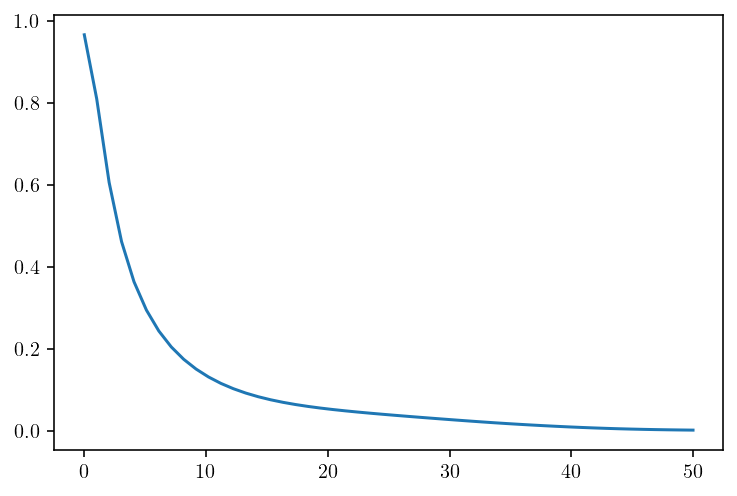

In [53]:
zl_ET = np.linspace(1e-8, 50, num=50)
plt.plot(zl_ET, fractz_ET)

In [14]:
hdul = fits.open(dir_out2+'fractz_ET_snrcorrect2_referee.fits')
data1 = hdul[1].data
zl_ET = data1['zl_ET']
rhooptl_ET = data1['rhooptl_ET']
fractz_ET = data1['fractz_ET']

In [15]:
hdul = fits.open(dir_out2+'fractz_ET_snrcorrect.fits')
data1 = hdul[1].data
zl_ET_old = data1['zl_ET']
rhooptl_ET_old = data1['rhooptl_ET']
fractz_ET_old = data1['fractz_ET']

No handles with labels found to put in legend.


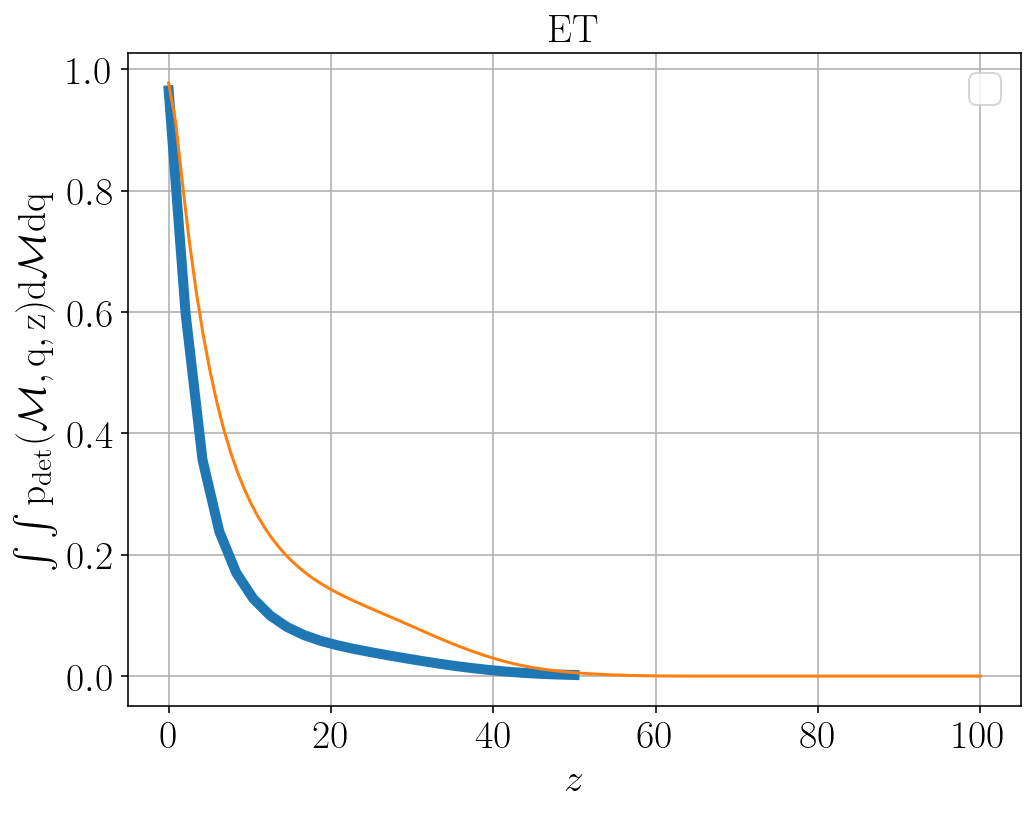

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(zl_ET, fractz_ET, linewidth=5)
plt.plot(zl_ET_old, fractz_ET_old)

plt.xlabel(r'$z$', fontsize=20)
plt.ylabel(r'$\rm \int \int p_{det}(\mathcal{M}, q, z) d\mathcal{M} dq$', fontsize=20)
plt.title(r'ET', fontsize=20)

plt.xticks(size=20)
plt.yticks(size=20)

plt.grid(True)
plt.legend(fontsize=20)


In [17]:
from constantfei import *
from optical_depthfei import *

"e(z)"
#Precaculated e(z) using Madau&Dickson SFR
hdul = fits.open(dir_out2+'e(z)fei_nodil.fits')
data2 = hdul[1].data
zl_madau = data2['zl']
ez_madau = data2['e(z)']
ezspl_madau = interpolate.interp1d(zl_madau, ez_madau, kind='linear', fill_value = 'extrapolate')
#Create a function for e(z)
def ef(z):
    if (ezspl_madau(z)>0):
        value = ezspl_madau(z)
    else:
        value = 0
        
    return value

efv = np.vectorize(ef)

"dR/dz original"
# Local merger rate measured by LIGO
r0 = 64.9/((constantfei.Gpc_m)**3)/(365*24*3600) #m^-3 s^-1

# dR/dz as a function of z
#Equation 6 in Sec 2.2
def dR_dz_org(z): #dR/dz original, number/year/z, detector frame
    r_c = cosmo.comoving_distance(z).value*constantfei.Mpc_m
    return r0*efv(z)/(1+z)*(4*np.pi*c*r_c*r_c/(cosmo.H(z).value*1e3/constantfei.Mpc_m))*(365*24*3600)
dR_dz_orgv = np.vectorize(dR_dz_org)


"R(<z)"
# Integrate dR/dz in the redshift sapce
def Rcumz_org(z):
    return integrate.quad(lambda zp: dR_dz_org(zp), 0, z)[0]
Rcumz_orgv = np.vectorize(Rcumz_org)


In [18]:
spl_test = interpolate.interp1d(zl_ET, fractz_ET, kind='linear')

In [19]:
integrate.quad(lambda x: dR_dz_orgv(x)*spl_test(x), np.min(zl_ET), np.max(zl_ET))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  """Entry point for launching an IPython kernel.


(96031.7556519528, 0.6660862187709427)

-2308

In [20]:
np.sqrt(2*1.67*1e-27*1.38*1e-23*290)

3.6560470456491666e-24

In [21]:
6.6e-34/3.7e-24

1.7837837837837838e-10